Tianyou Xiao (tx43), Ziyu Song (zs363)

CS 5785 HW 4 EM Algorithm and Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
%matplotlib inline

Text(0, 0.5, 'Waiting time (min)')

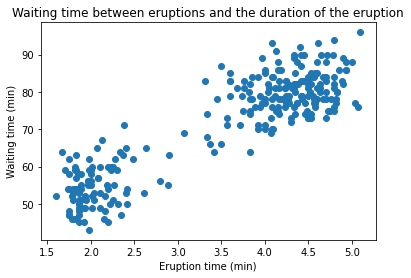

In [2]:
# url = 'http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat'
data = np.loadtxt('faithful.txt') 

x = data[:,1] # eruptions
y = data[:,2] # waiting

featureset = data[:, 1:]

plt.figure()
plt.title("Waiting time between eruptions and the duration of the eruption")
plt.scatter(x,y)
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time (min)")
# plt.savefig("faithful_ori.jpg")

In [40]:
# (b)
class models:
    def __init__(self,lambdas, mus, sigmas):
        self.lambdas=lambdas
        self.mus=mus
        self.sigmas=sigmas

def init_model(data, mus=None, sigmas=None, cluster_num=2):
    if mus is None:
        ctd_index = random.sample(range(272),2)
        mus = data[ctd_index]
    lambdas = np.random.rand(cluster_num)
    # mus = np.array([np.mean(featureset, axis=0), np.mean(featureset, axis=0)])
    # sigmas = np.zeros((2, 2))
    if sigmas is None:
        sigmas = np.cov(data.T)

    return models(lambdas, mus, sigmas)


def gmm(model, data, iterations=200, cluster_num=2):

    from scipy.stats import multivariate_normal
    mat = np.zeros((data.shape[0], cluster_num))

    # mus_over_time = np.ndarray((iterations, 2, 2))
    mus_over_time = [model.mus.copy()]

    for iter in range(iterations):
        # print(model.mus)
        tmp_mu = model.mus.copy()

        for j in range(data.shape[0]):
            # sum(k') lambda_k * exp(...)
            s = 0
            for i in range(cluster_num):
                s += (model.lambdas[i] * multivariate_normal(mean=model.mus[i], cov=model.sigmas).pdf(data[j]))
            for z in range(cluster_num):
                mat[j][z] = ((model.lambdas[z] * multivariate_normal(mean=model.mus[z], cov=model.sigmas).pdf(data[j])) / s)

        for i in range(cluster_num):
            # Nk: sum(n) of P(Z=k|X^n)
            Nk = sum([mat[x][i] for x in range(data.shape[0])])
            model.lambdas[i] = Nk / data.shape[0]

            model.mus[i] = sum([mat[x][i] * data[x] for x in range(data.shape[0])]) / Nk
            # print(model.mus)
            model.sigmas = sum([mat[x][i] / Nk * (np.array([data[x] - model.mus[i]]) * np.array([data[x] - model.mus[i]]).T) for x in range(data.shape[0])])

        # mus_over_time[iter] = model.mus
        mus_over_time.append(model.mus.copy())
        
        if np.linalg.norm(tmp_mu-model.mus) < 1e-2:
            break


    return model, mus_over_time

def extract_parameters(model):
    lambdas = model.lambdas
    mus = model.mus
    sigmas = model.sigmas
    return lambdas, mus, sigmas


In [41]:
model = init_model(featureset)
model, muses = gmm(model, featureset)

Text(0, 0.5, 'Waiting time (min)')

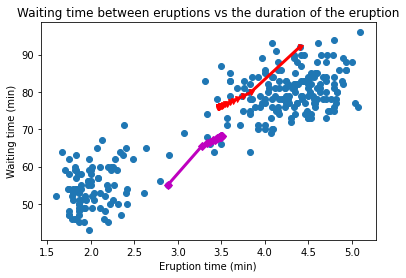

In [42]:
plt.figure()
plt.title("Waiting time between eruptions vs the duration of the eruption")
plt.scatter(x,y)
first = [i[0] for i in muses]
plt.plot([tmp1[0] for tmp1 in first], [tmp1[1] for tmp1 in first], 'rv-',markersize=5,linewidth=3)
second = [i[1] for i in muses]
plt.plot([tmp1[0] for tmp1 in second], [tmp1[1] for tmp1 in second], 'mD-',markersize=5,linewidth=3)
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time (min)")

In [43]:
iter_nums = np.zeros(50)
for i in range(50):
    model = init_model(featureset)
    model, muses = gmm(model, featureset)
    iter_nums[i] = len(muses)

In [39]:
iter_nums[0]

201.0

(array([4., 9., 2., 1., 0., 3., 1., 1., 3., 3., 0., 0., 0., 3., 0., 0., 2.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 2., 2., 0., 2., 4.,
        1., 0., 0., 1., 2., 1.]),
 array([ 5.   ,  6.875,  8.75 , 10.625, 12.5  , 14.375, 16.25 , 18.125,
        20.   , 21.875, 23.75 , 25.625, 27.5  , 29.375, 31.25 , 33.125,
        35.   , 36.875, 38.75 , 40.625, 42.5  , 44.375, 46.25 , 48.125,
        50.   , 51.875, 53.75 , 55.625, 57.5  , 59.375, 61.25 , 63.125,
        65.   , 66.875, 68.75 , 70.625, 72.5  , 74.375, 76.25 , 78.125,
        80.   ]),
 <BarContainer object of 40 artists>)

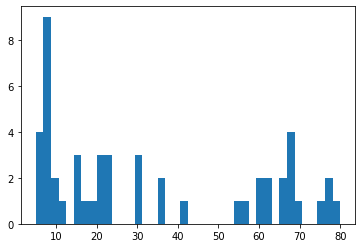

In [47]:
plt.hist(iter_nums, bins=40)

In [30]:
#(c)
# source: https://medium.com/@rishit.dagli/build-k-means-from-scratch-in-python-e46bf68aa875
class K_Means:
    def __init__(self, k=2, tol=0.001, max_iter=200):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}
        # random.seed(0)
        initial_centroids = random.sample([i for i in range(len(data))], self.k)

        for i in range(self.k):
            self.centroids[i] = data[initial_centroids[i]]

        for i in range(self.max_iter):
            self.classifications = {}
            self.pred = []

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                self.pred.append(classification)

            # prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)


    def predict(self, data=None):
        if data:
            classification = []
            for data in dataset:
                distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
                classification.append(distances.index(min(distances)))
            return np.asarray(classification)

        return np.asarray(self.pred)


    def evaluate(self, dataset):
        pred = self.predict()
        centroids = [self.centroids[i] for i in pred]
        error_sum =  0
        for i in range(len(centroids)):
            c = centroids[i]
            error_sum += np.linalg.norm(dataset[i]-c)

        return error_sum


In [31]:
kmeans = K_Means(k=2)
kmeans.fit(featureset)
pred = kmeans.predict()
estimated_sigma = np.cov(featureset[pred==0].T)*len(featureset[pred==0])/featureset.shape[0] + np.cov(featureset[pred==1].T)*len(featureset[pred==1])/featureset.shape[0]
model_2 = init_model(featureset, mus=np.array([kmeans.centroids[c] for c in kmeans.centroids]), sigmas=estimated_sigma)
model_2, muses_2 = gmm(model_2, featureset)

Text(0, 0.5, 'Waiting time (min)')

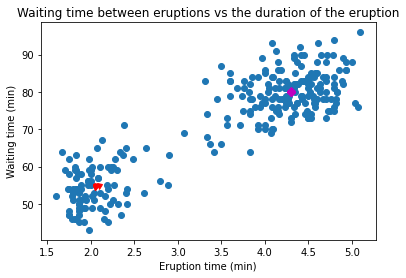

In [32]:
plt.figure()
plt.title("Waiting time between eruptions vs the duration of the eruption")
plt.scatter(x,y)
first = [i[0] for i in muses_2]
plt.plot([tmp1[0] for tmp1 in first], [tmp1[1] for tmp1 in first], 'rv-',markersize=5,linewidth=3)
second = [i[1] for i in muses_2]
plt.plot([tmp1[0] for tmp1 in second], [tmp1[1] for tmp1 in second], 'mD-',markersize=5,linewidth=3)
plt.xlabel("Eruption time (min)")
plt.ylabel("Waiting time (min)")

In [45]:
iter_nums_2 = np.zeros(50)
for i in range(50):
    model_2 = init_model(featureset, mus=np.array([kmeans.centroids[c] for c in kmeans.centroids]), sigmas=np.cov(featureset[pred==0].T))
    model_2, muses_2 = gmm(model_2, featureset)
    iter_nums_2[i] = len(muses_2)

(array([ 6.,  0.,  0.,  0.,  0., 26.,  0.,  0.,  0., 18.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 10 artists>)

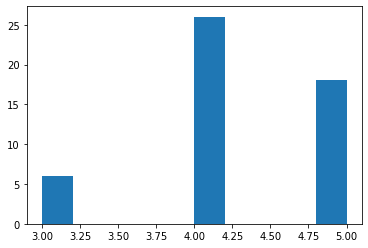

In [48]:
plt.hist(iter_nums_2)